In [1]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

from math import sqrt, pi

from data import Condition, gen

In [18]:
class myact(nn.Module):
    def forward(self,x):
        t=x * 2
        return t * torch.erf(t) + torch.exp(-torch.square(t))

In [51]:
class mynet(nn.Module):
    def __init__(self,act):
        super(mynet,self).__init__()

        self.main_node = [2,3,3,1]
        self.activate = act

        self.BCNet = nn.Sequential(
            nn.Linear(4*10*3,50),
            nn.Tanh(),
            nn.Linear(50,10),
            nn.Tanh(),
            nn.Linear(10,len(self.main_node) - 1)
        )

        layer_list = []

        for i,j in zip(self.main_node[:-1],self.main_node[1:]):
            layer_list.append(nn.Linear(i + 1,j))

        self.mainNet = nn.ModuleList(layer_list)
    
    def forward(self,x_IN,x_BC):
        additional_input = self.BCNet(x_BC)


        input = x_IN

        for i,layer in enumerate(self.mainNet[:-1]):
            input = torch.hstack((input,additional_input[:,i].view(-1,1)))
            input = layer(input)
            input = self.activate(input)

        return self.mainNet[-1](torch.hstack((input,additional_input[:,-1].view(-1,1))))

In [20]:
c = Condition(x_min = 0, x_max = 1, y_min = 0, y_max = 1, num_each_bc = 10)
data = gen(condition = c,
           n_data = 1000,
           mode = 0,
           BC_values = {'up':1,'down':0,'left':0,'right':0})

train_loader = DataLoader(data,batch_size = 32, shuffle = True)

In [52]:
model = mynet(nn.Tanh())
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr = 0.001)

In [22]:
def equation(net,in_cord,BC_data):
    T = net(in_cord,BC_data)
    dT = torch.autograd.grad(inputs=in_cord,
                             outputs=T,
                             grad_outputs=torch.ones_like(T),
                             create_graph=True,
                             retain_graph=True)[0]
    dTdx = dT[:,0]
    dTdy = dT[:,1]

    ddTddx= torch.autograd.grad(inputs=in_cord,
                                outputs=dTdx,
                                grad_outputs=torch.ones_like(dTdx),
                                create_graph=True,
                                retain_graph=True)[0][:,0]

    ddTddy = torch.autograd.grad(inputs=in_cord,
                                outputs=dTdy,
                                grad_outputs=torch.ones_like(dTdy),
                                create_graph=True,
                                retain_graph=True)[0][:,1]

    return ddTddx + ddTddy

In [53]:
verbose = 10
epoch = 1
history = []

crit = 1e-3
stand = 1e10

save_term = 10
checkpoint_path = 'model.pth'

while(stand >= crit):
    Total_Loss = 0
    Total_data_size = 0

    Total_Residual = 0
    Total_BC = 0

    for IN_cord, BC_input, BC_cord, BC_label in train_loader:
        optimizer.zero_grad()

        BC_pred = model(BC_cord,BC_input)
        BC_loss = loss_fn(BC_pred, BC_label.reshape(-1,1))


        Residual_pred = equation(model,IN_cord,BC_input)
        Residual = loss_fn(Residual_pred, torch.zeros_like(Residual_pred))

        total_loss = BC_loss + Residual

        total_loss.backward(retain_graph=True)
        optimizer.step()

        Total_Loss += total_loss * len(IN_cord)
        Total_data_size += len(IN_cord)

        Total_Residual += Residual * len(IN_cord)
        Total_BC += BC_loss * len(IN_cord)

        

    Total_Loss /= Total_data_size
    Total_BC /= Total_data_size
    Total_Residual /= Total_data_size
    if(epoch%verbose==0):
        print(f"Epoch : [{epoch}], Loss : {Total_Loss:.4f}, Residaul : {Total_Residual:.4f}, BC : {Total_BC:.4f}")

    history.append([epoch,Total_Loss.item(),Total_Residual.item(),Total_BC.item()])

    stand = Total_Loss.item()
    epoch += 1

    if(epoch % save_term == 0):
        torch.save({
            'epoch':epoch,
            'model_state_dict':model.state_dict(),
            'optimizer_state_dict':optimizer.state_dict(),
            'history':history
        },checkpoint_path)

history = np.array(history)

Epoch : [10], Loss : 0.1455, Residaul : 0.0055, BC : 0.1400
Epoch : [20], Loss : 0.1230, Residaul : 0.0102, BC : 0.1127
Epoch : [30], Loss : 0.1069, Residaul : 0.0074, BC : 0.0995
Epoch : [40], Loss : 0.0947, Residaul : 0.0047, BC : 0.0901
Epoch : [50], Loss : 0.0916, Residaul : 0.0037, BC : 0.0879
Epoch : [60], Loss : 0.0900, Residaul : 0.0032, BC : 0.0868
Epoch : [70], Loss : 0.0866, Residaul : 0.0032, BC : 0.0834
Epoch : [80], Loss : 0.0841, Residaul : 0.0032, BC : 0.0809
Epoch : [90], Loss : 0.0787, Residaul : 0.0026, BC : 0.0760
Epoch : [100], Loss : 0.0748, Residaul : 0.0030, BC : 0.0718
Epoch : [110], Loss : 0.0725, Residaul : 0.0037, BC : 0.0687
Epoch : [120], Loss : 0.0703, Residaul : 0.0042, BC : 0.0661
Epoch : [130], Loss : 0.0690, Residaul : 0.0045, BC : 0.0645
Epoch : [140], Loss : 0.0678, Residaul : 0.0045, BC : 0.0633
Epoch : [150], Loss : 0.0665, Residaul : 0.0045, BC : 0.0620
Epoch : [160], Loss : 0.0651, Residaul : 0.0043, BC : 0.0608
Epoch : [170], Loss : 0.0632, Res

In [4]:
# if want load
checkpoint_path = 'model.pth'

model = mynet(nn.Tanh())
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr = 0.001)

checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

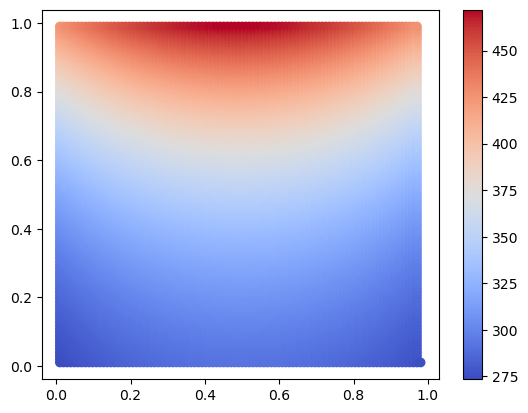

In [46]:
T_max = 500
T_min = 300

n = 100

c = Condition(x_min = 0, x_max = 1, y_min = 0, y_max = 1, num_each_bc = 10)
test = gen(condition = c,
           n_data = n**2,
           mode = 0,
           BC_values = {'up':1,'down':0,'left':0,'right':0})

test_loader = DataLoader(test,batch_size = n, shuffle = False)

T = []
cord = []

for IN_cord, BC_input, BC_cord, BC_label in test_loader:
    T.append(model(IN_cord,BC_input))
    cord.append(IN_cord)

T = torch.vstack(T)
T = T * (T_max - T_min) + T_min
cord = torch.vstack(cord)
x_cord = cord[:,0]
y_cord = cord[:,1]

plt.scatter(x_cord.detach().numpy().reshape([n,n]),y_cord.detach().numpy().reshape([n,n]),c=T.detach().numpy().reshape([n,n]),cmap='coolwarm')
plt.colorbar()

In [ ]:
e = history[:,0]
T_Loss = history[:,1]
R = history[:,2]
B = history[:,3]

In [ ]:
plt.plot(e,R/T_Loss * 100,label = 'R / Total')
plt.plot(e,B/T_Loss * 100,label = 'BC / Total')
plt.title('f act')
plt.ylabel('Loss ratio (%)')
plt.xlabel('Epoch (n)')
plt.legend()

In [15]:
a = None
a != None

False